# 듀얼 모멘텀

| 항목  |      설명      |
|------|:----------- -:|
| 스타일 |  듀얼 모멘텀 |
| 기대 CAGR | 10-15%   |
| 매수 전략 | S&P 500, Euro Stoxx, Nikkei, Kospi 중 최근 6개월간 가장 많이 상승한 지수를 추종하는 ETF에 투자 |
| | 그런데 4개 지수 모두 6개월 수익률이 예금금리 이하로 하락하면 모든 ETF매도 후 현금 보유.
| 매도 전략 | 월 1회 리밸런싱

In [1]:
from lib.utils.logging import configure_logger
%load_ext autoreload
%autoreload 2
configure_logger()

## Data preparation

다른 전략들의 백테스트와 마찬가지로 실제 ETF종목 대신 긴 기간을 테스트 할 수 있는 지수의 종가 데이터를 사용합니다.
매수전략에 나오는 Euro Stoxx의 경우 Yahoo Finance에서 지수 데이터를 찾을 수가 없어 KOSPI, NIKKEI, S&P 세 지수로 테스트 합니다.

In [3]:
from lib.utils.data_utils import load_data, sync_market_days
import investpy

kospi_df = load_data('^KS11')
nikkei_df = load_data('^N225')
snp_df = load_data('^GSPC')

# (중요!!) 서로 다른 거래소의 종목 혹은 지수로 포트폴리오를 구성하는 경우 거래일의 교집합을 사용합니다.
kospi_df, nikkei_df, snp_df = sync_market_days(kospi_df, nikkei_df, snp_df)

## Develope your strategy

각 지표(종목)의 최근 6개월 모멘텀을 비교해서 가장 높은 종목으로 포트폴리오를 유지합니다. 
의사코드롤 표현하면 아래와 같습니다.


    securiy = get_the_best_security()
    if security.rate_of_change < saving_interest:
        sell(cur_position)
        return
        
    if cur_position != security:
        sell(cur_position)
        buy(security)
        return


## Run back-test.

In [4]:
import backtrader as bt

from lib.strategies.dual_momentum_strategy import DualmomentumStrategy
from lib.utils.runtime_util import create_and_configure_cerebro

# Create a backtest runtime.
initial_cash = 1000000
cerebro = create_and_configure_cerebro(
    DualmomentumStrategy,
    {
        bt.feeds.PandasData(dataname=kospi_df): dict(name='KOSPI'),
        bt.feeds.PandasData(dataname=nikkei_df): dict(name='NIKKEI225'),
        bt.feeds.PandasData(dataname=snp_df): dict(name='S&P500')
    },
    initial_cash=initial_cash,
    strategy_params=dict(buy_margin=0.02, momentum_period=120, saving_interest=0.02)
)

# Run it!
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
dm_res = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
Final Portfolio Value: 6030559.93


## Visualize your strategy

<IPython.core.display.Javascript object>


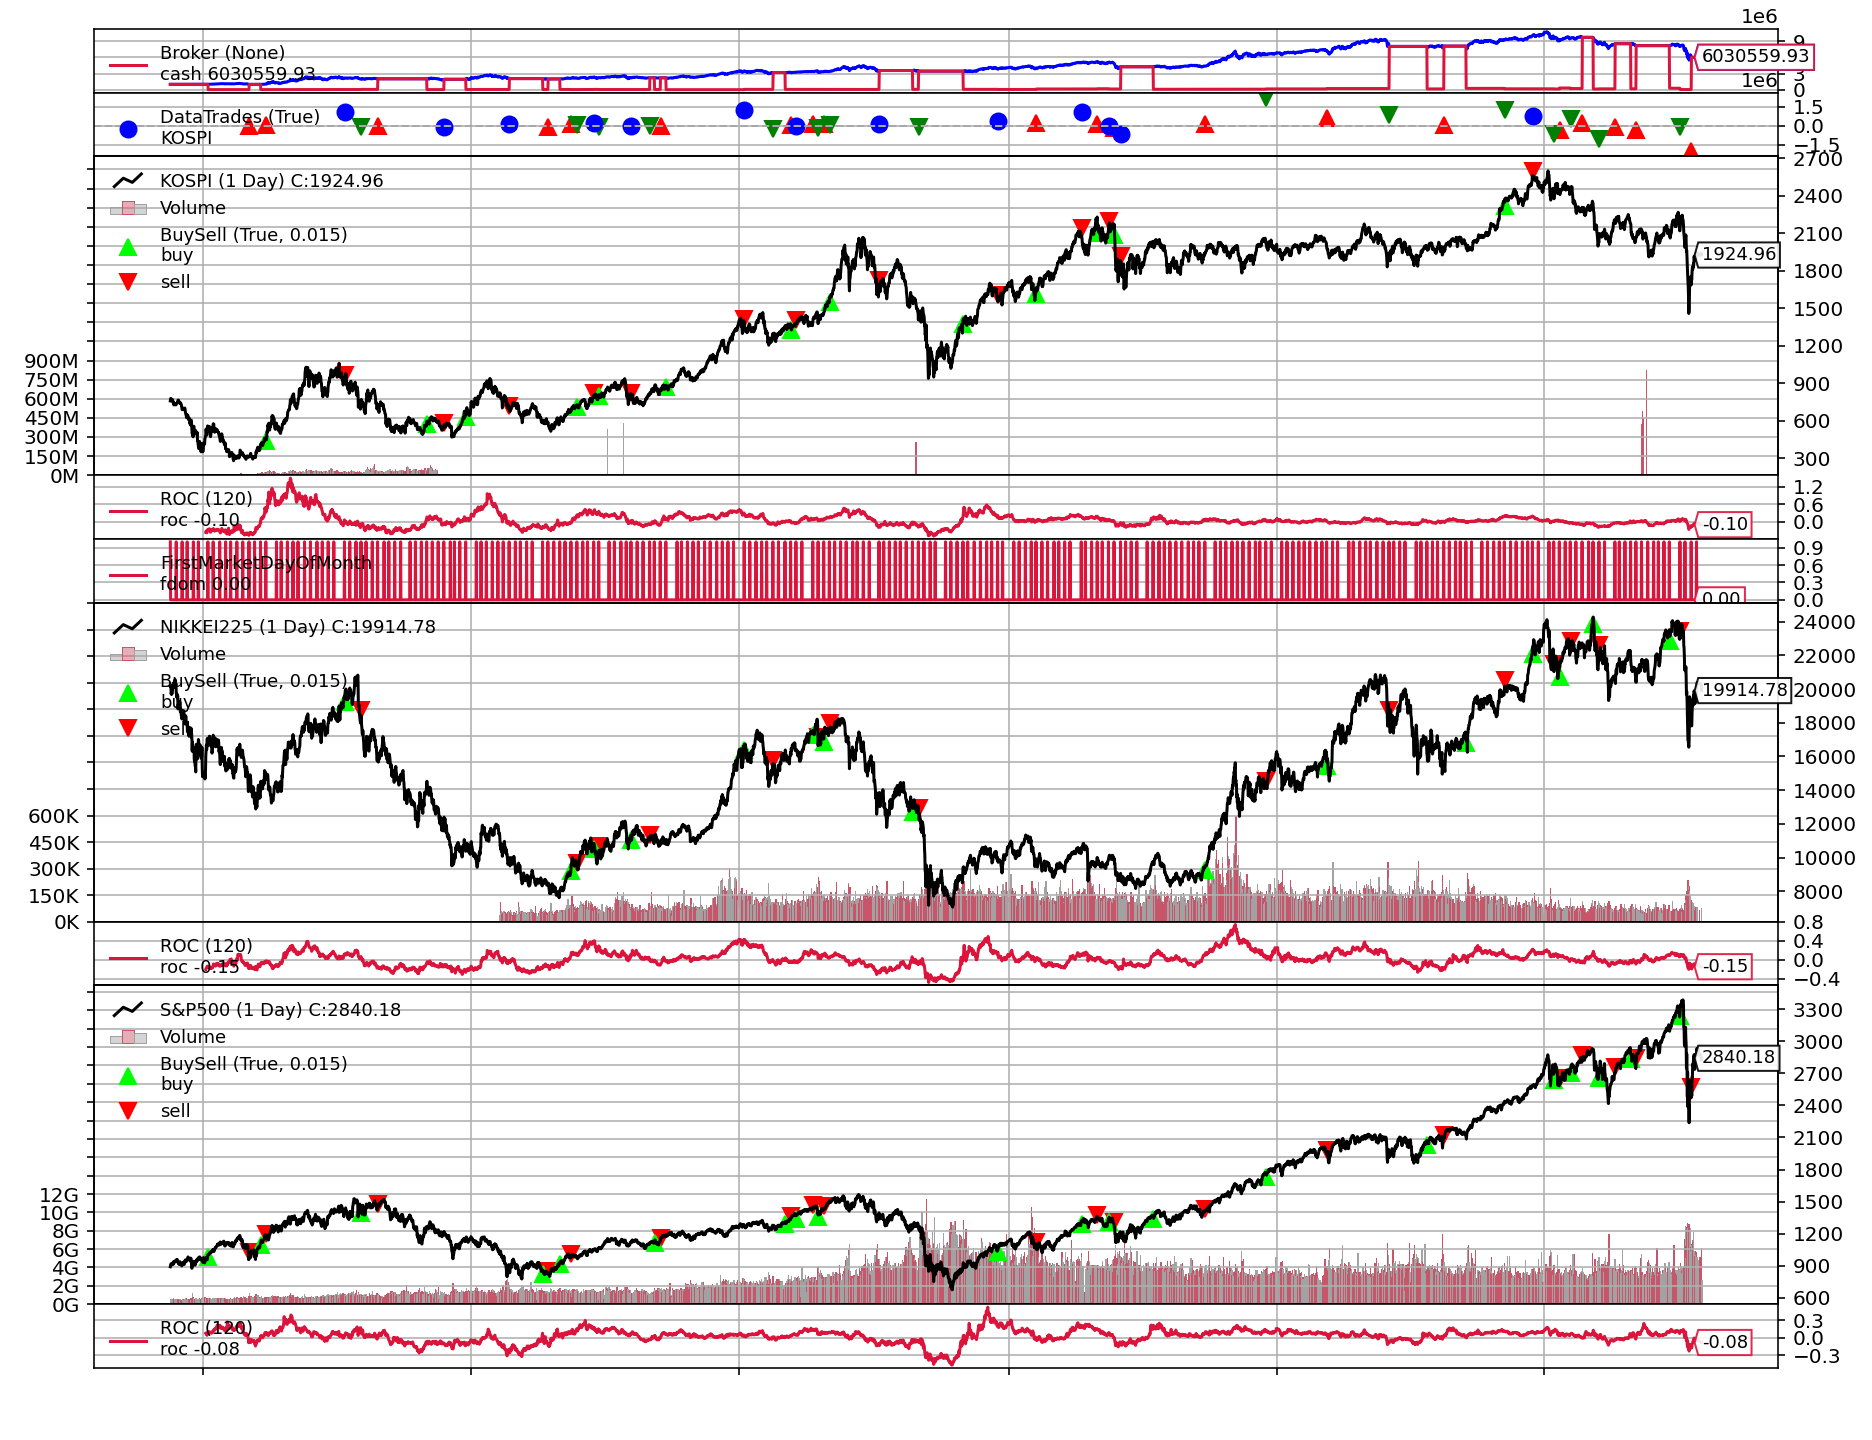

[[<Figure size 936x720 with 12 Axes>]]

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,10)
cerebro.plot()

or 
## Analyze the performance by yourself.

In [6]:
%matplotlib inline
import empyrical as ep
import pandas as pd

from lib.utils.analyzer_utils import get_annual_return_analysis_df, get_pos_values_analysis_df, get_default_perf_analysis_df

pd.set_option('float_format', '{:.3f}'.format)

dm_annual_return_df = get_annual_return_analysis_df(dm_res[0])
dm_pos_values_df = get_pos_values_analysis_df(dm_res[0])
dm_perf_report_df = get_default_perf_analysis_df(dm_res[0], 'Dual Momentum')
dm_perf_report_df

,initial_value,final_value,period_start,period_end,best_year,worst_yaer,mean,stddev,sharpe_ratio,mdd,cagr
Dual Momentum,1000000.000,6030559.931,1997-07-01,2020-05-14,0.620,-0.263,0.100,0.229,0.382,49.091,0.081


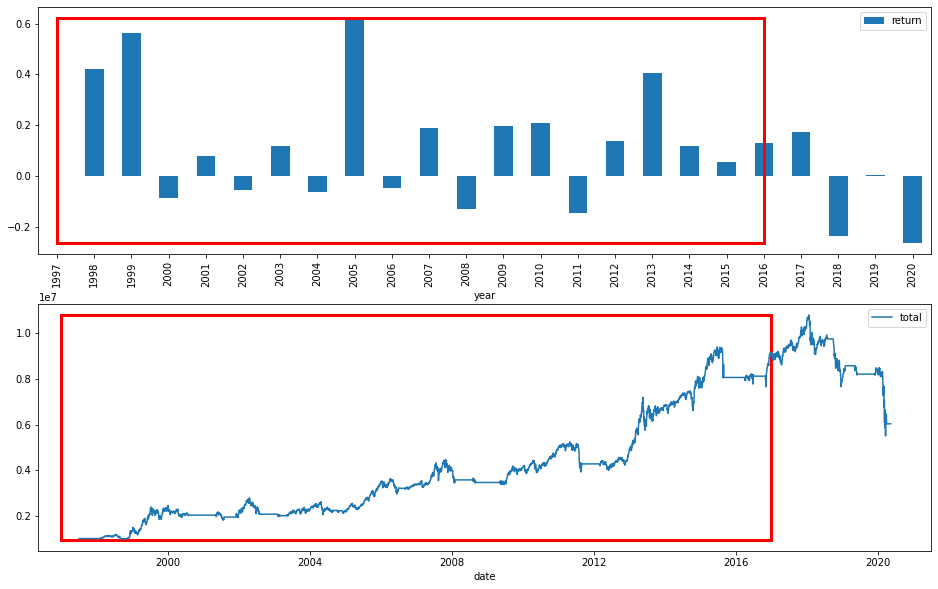

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import date
import matplotlib.dates as mdates


plt.rcParams["figure.figsize"] = (16,10)
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

dm_annual_return_df.plot.bar(ax=ax1)
dm_pos_values_df[['total']].plot(ax=ax2)

# bar chart box patch
start_x = 1997 - dm_annual_return_df.index.min()
end_x = 2016 - dm_annual_return_df.index.min()
width = end_x - start_x

start_y = dm_annual_return_df['return'].min()
end_y = dm_annual_return_df['return'].max()
height = end_y - start_y

rect = patches.Rectangle((start_x, start_y), width, height, linewidth=3, edgecolor='r', facecolor='none')
ax1.add_patch(rect)


# line chart box patch
start_x = mdates.date2num(date(1997, 1, 1))
end_x = mdates.date2num(date(2016, 12, 31))
width = end_x - start_x
start_y = dm_pos_values_df['total'].min()
end_y = dm_pos_values_df['total'].max()
height = end_y - start_y

rect = patches.Rectangle((start_x, start_y), width, height, linewidth=3, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

책에서 백테스트 했던 기간(빨간 상자 안)으로 한정하면 굉장히 인상적인 결과가 나오겠지만 불행하게도 그 이후 2020년 5월까지의 전 기간으로 확대해서 테스트를 해보면 그다지 매력적이지 않은 모델로 보인다. 특히 2020년의 대폭락은 매월 정해진 시점에 리밸런싱을 하는 전략의 특성 상 짧은 기간에 폭락이 진행되었던 지난 4-5월 사이에 재빠르게 대응하지 못한게 원인이 된것 같다. 

어쨌던 주어진 데이터에서 듀얼모멘텀 전략이 보여주는 테스트 결과가 정말 책에서 이야기 하는 대로 MDD 축소에 좋은 절대모멘텀과 알파 창출에 유리한 상대적모멘텀 전략을 섞은 효과가 있는지 확인해 보고 싶다.

# Benchmark test

벤치마크를 위해 코스피 지수를 절대적 모멘텀 전략으로 동일 기간 투자했을 때의 테스트 결과와 듀얼모멘텀의 테스트 결과를 교차 비교 한다.

In [8]:
# Scenario 1
from lib.strategies.sma_momentum_strategy import SMAMomentumStrategy
from lib.utils.analyzer_utils import get_annual_return_analysis_df, get_default_perf_analysis_df, get_pos_values_analysis_df
kospi_cerebro = create_and_configure_cerebro(
    SMAMomentumStrategy,
    {
        bt.feeds.PandasData(dataname=kospi_df): dict(name='KOSPI'),
    },
    strategy_params=dict(maperiod=60, buy_margin=0.03, rocperiod=7),
    initial_cash=initial_cash
)

# Run it!
print('Starting Portfolio Value: %.2f' % kospi_cerebro.broker.getvalue())
kospi_res = kospi_cerebro.run()
print('Final Portfolio Value: %.2f' % kospi_cerebro.broker.getvalue())

kospi_annual_return_df = get_annual_return_analysis_df(kospi_res[0])
kospi_pos_values_df = get_pos_values_analysis_df(kospi_res[0])
kospi_perf_report_df = get_default_perf_analysis_df(kospi_res[0], 'SMAMomentum_KOSPI')

Starting Portfolio Value: 1000000.00
Final Portfolio Value: 5744589.30


In [9]:
import pandas as pd
overall_report_df = pd.concat([dm_perf_report_df, kospi_perf_report_df])
overall_report_df

,initial_value,final_value,period_start,period_end,best_year,worst_yaer,mean,stddev,sharpe_ratio,mdd,cagr
Dual Momentum,1000000.000,6030559.931,1997-07-01,2020-05-14,0.620,-0.263,0.100,0.229,0.382,49.091,0.081
SMAMomentum_KOSPI,1000000.000,5744589.295,1997-07-01,2020-05-14,0.519,-0.309,0.088,0.170,0.471,43.230,0.079


테스트 결과, 책에서 언급한 대로 절대적 모멘텀 전략이 MDD방어에 6% 포인트가까이 우위를 보인 반면 연복리 수익은 듀얼 모멘텀에 살짝 못 미치는 결과를 보인다. 테스트 결과 보여준 절대값 자체는 아주 매력적이지는 않지만 그래도 전략이 의도하는 바가 그대로 구현되는 모습은 긍정적이라고 생각한다.

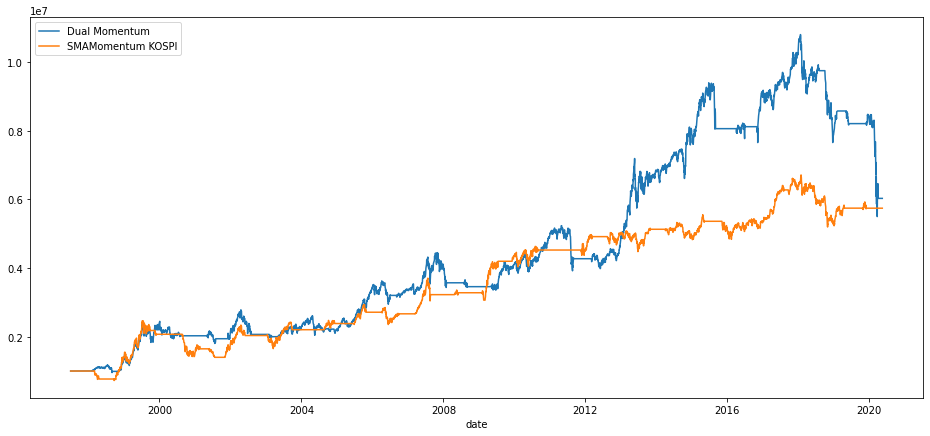

In [10]:
df = pd.DataFrame()
df['Dual Momentum'] = dm_pos_values_df['total']
df['SMAMomentum KOSPI'] = kospi_pos_values_df['total']

plt.rcParams["figure.figsize"] = (16,7)
df.plot()

시간의 흐름에 따른 가치의 변동 추이를 보면 두 전략의 특성을 좀 더 한눈에 대조해 볼 수 있다. 
단일 지수를 대상으로 절대적 모멘텀을 추종한 벤치마크 결과(주황색선)의 경우 해당 지수의 상승폭 이상의 수익을 기대할 수 없으나 하락장의 경우 손절매가 좀더 빠르고 그에 따라 하락폭이 제한되는 반면 듀얼 모멘텀의 경우 복수의 지수(종목)을 좀 더 공격적으로 투자하지만 변동성역시 드라마틱하게 커지는 모습을 보인다.

## 맺음

사실 이 책을 처음 접하고 실제로 백테스트를 돌려보기로 결심하게 된 계기가 된 전략이 듀얼 모멘텀 전략이었다.
이론적으로는 방어적이면서도 공격적으로 이율을 추구하는 조화로운 형태이고, 또 책에서 주어진 백테스트 기간을 동일하게 적용했을 시에는 정말 마법의 공식을 발견한 것처럼 잘 들어맞았기 때문이다. 비록 책에서 주어진 백테스트 기간이 최신의 경향을 반영하지 못하긴하지만 그 기간동안에도 IMF나 금융위기같은 대 폭락장이 두번이나 있었음을 생각해 보면 누구라도 기대를 갖게 하지 않았을까.

다음 테스트로는 현재의 DualMomentumStrategy 클래스를 확장해서 리밸런싱 기간 사이에 좀 더 적극적으로 손절매를 하도록 해보면 어떨까 싶다.